In [3]:
# basic dependencies
from pathlib import Path
if Path.cwd().parent.stem == 't3':
    %cd ..

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/compVision-DCC/t3
    
    assert torch.__version__.startswith("1.8")   
    try: 
        import detectron2
    except ImportError:
        !pip install pyyaml>=5.1
        !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
else:
    %config Completer.use_jedi = False

/workspace/compVision-DCC/t3
1.7.1 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
print(detectron2.__version__)
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

0.4


In [5]:
import io
import cv2
import numpy as np
from IPython.display import clear_output, Image, display
import PIL.Image

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

# Train on a custom dataset

## Prepare the dataset

Register the dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. User should write such a function when using a dataset in custom format. See the tutorial for more details.


In [6]:
from pathlib import Path
from detectron2.structures import BoxMode

def get_mnist_dict(base_dir: str):
    base_dir = Path(base_dir)
    img_dir = Path(base_dir) / "images"
    annot_dir = Path(base_dir) / "labels"

    dataset_dicts = []
    for idx, annot_f in enumerate(annot_dir.iterdir()):
        
        # print(annot)
        filename = annot_f.stem + '.png'
        filename = img_dir / filename

        if not filename.exists():
            continue
            
        height, width = cv2.imread(str(filename)).shape[:2]

        with open(annot_f) as f:
            img_annots = f.readlines()[1:]

        record = {}
        record["file_name"] = str(filename)
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        objs = []
        for annot in img_annots:
            # example: 4,83,8,43,53
            
            category_bbox_str = annot.split(',')
            category_str, bbox_str = category_bbox_str[0], category_bbox_str[1:]
            
            bbox = [int(p_str.replace('\n', '').strip()) for p_str in bbox_str]
            obj = {
                "bbox": bbox,
                "bbox_mode": BoxMode.XYXY_ABS,
                # "segmentation": [poly],
                "category_id": int(category_str),
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [7]:
!ls 'data/mnist_detection_150_500/train/labels' -1 | wc -l

10000


In [8]:
data_path = Path('data/mnist_detection_150_500')

for d in ["train", "test"]:
    DatasetCatalog.register("mnist_" + d, lambda d=d: get_mnist_dict(data_path / d))
    MetadataCatalog.get("mnist_" + d).set(thing_classes=[str(i) for i in range(10)])

mnist_metadata_test = MetadataCatalog.get("mnist_test")
mnist_metadata = MetadataCatalog.get("mnist_train")

In [9]:
from detectron2.data.datasets.coco import register_coco_instances, convert_to_coco_dict
import json

mnist_coco_dict = convert_to_coco_dict("mnist_test")

with open('mnist_coco.json', 'w') as fp:
    json.dump(mnist_coco_dict, fp)
    
register_coco_instances("mnist-test", {}, "mnist_coco.json", "")

[06/16 04:43:39 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[06/16 04:43:40 d2.data.datasets.coco]: Conversion finished, #images: 1000, #annotations: 5482


{'file_name': 'data/mnist_detection_150_500/train/images/269.png', 'image_id': 5745, 'height': 150, 'width': 500, 'annotations': [{'bbox': [202, 37, 255, 99], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 7}, {'bbox': [428, 44, 482, 111], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 6}, {'bbox': [397, 27, 435, 75], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 6}, {'bbox': [483, 37, 495, 50], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 6}, {'bbox': [357, 24, 390, 65], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 8}, {'bbox': [88, 37, 111, 74], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 9}, {'bbox': [236, 10, 265, 44], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 7}]}


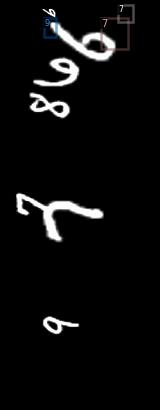

In [10]:
import detectron2.data.transforms as T

dataset_dicts = get_mnist_dict(data_path / "train")

transform_list = [
        T.Resize((300,800)),
        T.PadTransform(10, 10, 10, 10),
        T.RandomBrightness(0.8, 1.8),
        T.RandomContrast(0.6, 1.3),
        T.RandomSaturation(0.8, 1.4),
        T.RandomRotation(angle=[90, 90]),
        T.RandomLighting(0.7),
        T.RandomFlip(prob=0.4, horizontal=False, vertical=True),
    ]

augs = T.AugmentationList(transform_list)

for d in random.sample(dataset_dicts,1):
    print(d)
    boxes = np.array([annot['bbox'] for annot in d['annotations']])
    img = cv2.imread(d["file_name"])
    input = T.AugInput(img, boxes=boxes.astype('float32'))
    transform = augs(input)  # type: T.Transform
    image_transformed = input.image  # new image
    
    visualizer = Visualizer(image_transformed[:, :, ::-1], metadata=mnist_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    showarray(out.get_image()[:, :, ::-1])

In [11]:
# dataset_dicts = get_mnist_dict(data_path / "train")
# for d in random.sample(dataset_dicts,1):
#     print(d)
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=mnist_metadata, scale=0.5)
#     out = visualizer.draw_dataset_dict(d)
#     showarray(out.get_image())

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [12]:
!rm -r output/

In [1]:
0.0002

0.0002

In [2]:
1e-4

0.0001

In [ ]:
from detectron2.engine import DefaultTrainer

from utils.trainer import MyTrainer
from TridentNet.tridentnet import add_tridentnet_config

cfg = get_cfg()
add_tridentnet_config(cfg)

cfg.merge_from_file('TridentNet/configs/tridentnet_fast_R_50_C4_3x.yaml')
cfg.DATASETS.TRAIN = ("mnist_train",)
cfg.DATASETS.TEST = ("mnist-test",)
cfg.TEST.EVAL_PERIOD = 250
cfg.DATALOADER.NUM_WORKERS = 9
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/detectron2/TridentNet/tridentnet_fast_R_50_C4_1x/148572687/model_final_756cda.pkl'
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00020  # pick a good LR
cfg.SOLVER.MAX_ITER = 2500    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset

cfg.SOLVER.STEPS = []        # do not decay learning rate

# faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32 
# see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/16 04:44:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

[06/16 04:44:08 d2.data.build]: Removed 0 images with no usable annotations. 10000 images left.
[06/16 04:44:08 d2.data.build]: Distribution of instances among all 10 categories:
|  category  | #instances   | category   | #instances   | category   | #instances   |
|:----------:|:-------------|:-----------|:-------------|:-----------|:-------------|
|     0      | 5404         | 1          | 6207         | 2          | 5480         |
|     3      | 5498         | 4          | 5554         | 5          | 4919         |
|     6      | 5435         | 7          | 5652         | 8          | 5450         |
|     9      | 5524         |            |              |            |              |
|   total    | 55123        |            |              |            |              |
[06/16 04:44:08 d2.data.build]: Using training sampler TrainingSampler
[06/16 04:44:08 d2.data.common]: Serializing 10000 elements to byte tensors and concatenating them all ...
[06/16 04:44:09 d2.data.common]: Serializ

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (11, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (11,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (40, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (40,) in the model! You might want to double check if this is expected.


[06/16 04:44:09 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.8/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[06/16 04:44:14 d2.utils.events]:  eta: 0:07:39  iter: 19  total_loss: 4.525  loss_cls: 2.501  loss_box_reg: 1.958  loss_rpn_cls: 0.01325  loss_rpn_loc: 0.01347  time: 0.1863  data_time: 0.0261  lr: 3.9962e-06  max_mem: 1587M
[06/16 04:44:17 d2.utils.events]:  eta: 0:07:41  iter: 39  total_loss: 4.503  loss_cls: 2.472  loss_box_reg: 1.99  loss_rpn_cls: 0.02236  loss_rpn_loc: 0.01484  time: 0.1870  data_time: 0.0049  lr: 7.9922e-06  max_mem: 1587M
[06/16 04:44:21 d2.utils.events]:  eta: 0:07:37  iter: 59  total_loss: 4.391  loss_cls: 2.407  loss_box_reg: 1.959  loss_rpn_cls: 0.01403  loss_rpn_loc: 0.01011  time: 0.1868  data_time: 0.0046  lr: 1.1988e-05  max_mem: 1587M
[06/16 04:44:25 d2.utils.events]:  eta: 0:07:30  iter: 79  total_loss: 4.343  loss_cls: 2.346  loss_box_reg: 1.952  loss_rpn_cls: 0.01017  loss_rpn_loc: 0.01067  time: 0.1865  data_time: 0.0045  lr: 1.5984e-05  max_mem: 1587M
[06/16 04:44:29 d2.utils.events]:  eta: 0:07:26  iter: 99  total_loss: 4.157  loss_cls: 2.203  lo

[06/16 04:46:34 d2.engine.defaults]: Evaluation results for mnist-test in csv format:
[06/16 04:46:34 d2.evaluation.testing]: copypaste: Task: bbox
[06/16 04:46:34 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[06/16 04:46:34 d2.evaluation.testing]: copypaste: 2.2172,6.0112,0.8220,2.1824,2.7980,nan
[06/16 04:47:44 d2.utils.events]:  eta: 0:06:58  iter: 259  total_loss: 3.459  loss_cls: 1.547  loss_box_reg: 1.874  loss_rpn_cls: 0.01204  loss_rpn_loc: 0.01066  validation_loss: 3.62  time: 0.1868  data_time: 0.0049  lr: 5.1948e-05  max_mem: 2536M
[06/16 04:47:47 d2.utils.events]:  eta: 0:06:54  iter: 279  total_loss: 3.426  loss_cls: 1.472  loss_box_reg: 1.897  loss_rpn_cls: 0.008533  loss_rpn_loc: 0.009665  validation_loss: 3.62  time: 0.1870  data_time: 0.0049  lr: 5.5944e-05  max_mem: 2536M
[06/16 04:47:51 d2.utils.events]:  eta: 0:06:52  iter: 299  total_loss: 3.408  loss_cls: 1.47  loss_box_reg: 1.901  loss_rpn_cls: 0.01044  loss_rpn_loc: 0.009398  validation_loss: 3.62

[06/16 04:50:10 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[06/16 04:50:10 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| 0          | 24.215 | 1          | 24.637 | 2          | 10.778 |
| 3          | 4.713  | 4          | 15.152 | 5          | 2.881  |
| 6          | 9.048  | 7          | 10.323 | 8          | 7.140  |
| 9          | 5.705  |            |        |            |        |
[06/16 04:50:11 d2.engine.defaults]: Evaluation results for mnist-test in csv format:
[06/16 04:50:11 d2.evaluation.testing]: copypaste: Task: bbox
[06/16 04:50:11 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[06/16 04:50:11 d2.evaluation.testing]: copypaste: 11.4593,26.6992,6.1824,13.2064,11.0600,nan
[06/16 04:51:19 d2.utils.events]:  eta: 0:06:17  iter: 499  total_loss: 2.927  loss_cls: 1.114  loss_b

In [ ]:
experiment_folder = 'output'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')


In [ ]:
import json
import matplotlib.pyplot as plt

experiment_folder = 'output'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')

ax1.plot(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x],
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x], color="red", label="Total Loss")

ax1.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x], color="blue", label="Val Loss")
    
ax1.tick_params(axis='y')
plt.legend(loc='upper left')
plt.show()


In [ ]:
from detectron2.checkpoint import Checkpointer
ckpt = Checkpointer(trainer.model, "models")
ckpt.save("best_mnist-trident")

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    showarray(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("balloon_val", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "balloon_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`